✅ All packages installed successfully!
TensorFlow version: 2.19.0
Keras Tuner version: 1.4.7
📊 Generating dataset...
Dataset shape: (1000, 6)
       f_GHz       W_mm       L_mm         er      h_mm  loss_tangent
0   5.119941  18.871490  14.129839   4.014303  1.154264      0.013487
1  11.457857   6.376134   4.380667   7.510629  1.117447      0.015954
2   9.051933   6.773091   3.854261  10.754869  2.765636      0.005084
3   7.585243   8.741495   6.188956   9.375804  1.123865      0.012535
4   2.716205  23.275396  17.184220  10.104299  1.179874      0.011478
✅ Data preparation complete!
🧠 Creating model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,922 (132.51 KB)

 Trainable params: 33,922 (132.51 KB)

 Non-trainable params: 0 (0.00 B)

🚀 Starting training...
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - constraint_satisfaction_metric: 93.9850 - loss: 401.7126 - mae: 15.1965 - val_constraint_satisfaction_metric: 100.0000 - val_loss: 394.9818 - val_mae: 14.0998 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - constraint_satisfaction_metric: 100.0000 - loss: 320.8666 - mae: 12.7648 - val_constraint_satisfaction_metric: 100.0000 - val_loss: 253.5529 - val_mae: 9.8155 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - constraint_satisfaction_metric: 100.0000 - loss: 173.8258 - mae: 8.1347 - val_constraint_satisfaction_metric: 100.0000 - val_loss: 93.3300 - val_mae: 5.3880 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - constraint_satisfaction_metric: 100.0000 - loss: 59.3417 - mae: 4.6688 - val_constraint_satisfaction_metric: 100.0000 - val_loss: 48.0506 - val_mae: 4.5901 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 

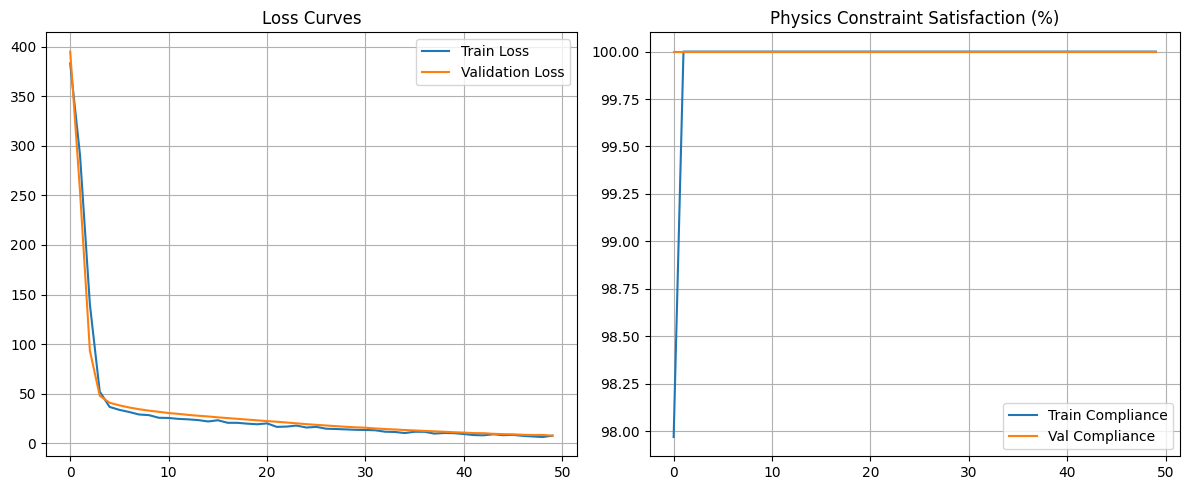

💾 Model and scalers saved successfully!
🌐 Launching Gradio interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d66becaf4c96bd37b2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d66becaf4c96bd37b2.gradio.live


In [ ]:
# Inverse Design of Patch Antennas
# ======================================================

# 1. Environment Setup with proper installation
# ---------------------
!pip install -q tensorflow numpy pandas matplotlib scikit-learn keras-tuner gradio joblib

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
import gradio as gr
import json
import os
import joblib

# Set random seeds for full reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All packages installed successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras Tuner version: {kt.__version__}")
print(f"Gradio version: {gr.__version__}")

# 2. Dataset Generation (Physics-Constrained)
# --------------------------------------------
def generate_antenna_dataset(num_samples=30000):
    c = 3e8  # Speed of light (m/s)

    # Design parameters
    f = np.random.uniform(1e9, 12e9, size=num_samples)
    er = np.random.uniform(2.2, 12.0, size=num_samples)
    h = np.random.uniform(0.5e-3, 3e-3, size=num_samples)
    loss_tangent = np.random.uniform(0.0001, 0.02, size=num_samples)

    # Analytical formulas for patch antenna
    W = np.clip(c / (2*f) * np.sqrt(2/(er+1)), 1e-3, 300e-3)
    eps_eff = (er+1)/2 + (er-1)/(2*np.sqrt(1+12*h/W))
    delta_L = 0.412*h*((eps_eff+0.3)*(W/h+0.264))/((eps_eff-0.258)*(W/h+0.8))
    L = np.clip(c / (2*f*np.sqrt(eps_eff)) - 2*delta_L, 1e-3, 300e-3)

    # Add realistic fabrication noise
    W_noisy = W * np.random.normal(1.0, 0.015, size=num_samples)
    L_noisy = L * np.random.normal(1.0, 0.015, size=num_samples)

    # Build dataset with physical enforcement: W >= 1.05*L
    data = pd.DataFrame({
        'f_GHz': f/1e9,
        'W_mm': np.maximum(W_noisy*1e3, L_noisy*1e3 * 1.05),
        'L_mm': L_noisy*1e3,
        'er': er,
        'h_mm': h*1e3,
        'loss_tangent': loss_tangent
    })

    return data

print("📊 Generating dataset...")
data = generate_antenna_dataset(1000)  # Smaller dataset for quick testing
print(f"Dataset shape: {data.shape}")
print(data.head())

# 3. Data Preparation
# --------------------
X = data[['f_GHz', 'er']].values
y = data[['L_mm', 'W_mm']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print("✅ Data preparation complete!")

# 4. Model Definition (Physics-Aware Loss)
# ----------------------------------------
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    constraint_penalty = tf.reduce_mean(tf.square(tf.maximum(1.05*y_pred[:,0] - y_pred[:,1], 0)))
    return mse + 0.001 * constraint_penalty

def constraint_satisfaction_metric(y_true, y_pred):
    return tf.reduce_mean(tf.cast(y_pred[:,1] >= 1.05 * y_pred[:,0], tf.float32)) * 100

# Simple model without hyperparameter tuning for quick testing
def create_simple_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=custom_loss,
        metrics=['mae', constraint_satisfaction_metric]
    )
    return model

print("🧠 Creating model...")
model = create_simple_model()
model.summary()

# 5. Training with Callbacks
# ---------------------------
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1)

print("🚀 Starting training...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,  # Reduced for quick testing
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 6. Evaluation
# --------------
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Enforce constraint at prediction
y_pred[:,1] = np.maximum(y_pred[:,1], y_pred[:,0]*1.05)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
compliance = constraint_satisfaction_metric(
    tf.convert_to_tensor(y_test, dtype=tf.float32),
    tf.convert_to_tensor(y_pred, dtype=tf.float32)
).numpy()

print("\n=== 📊 Evaluation Results ===")
print(f"MAE: {mae:.3f} mm")
print(f"R² Score: {r2:.4f}")
print(f"Physics Compliance: {compliance:.2f}%")

# 7. Visualization
# -----------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['constraint_satisfaction_metric'], label='Train Compliance')
plt.plot(history.history['val_constraint_satisfaction_metric'], label='Val Compliance')
plt.title('Physics Constraint Satisfaction (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 8. Save Model and Scalers
# --------------------------
!mkdir -p models

model.save("models/patch_antenna_model.h5")
joblib.dump(X_scaler, "models/x_scaler.pkl")
joblib.dump(y_scaler, "models/y_scaler.pkl")

print("💾 Model and scalers saved successfully!")

# 9. Gradio Interface (FIXED VERSION)
# --------------------
def plot_antenna(L, W):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.add_patch(plt.Rectangle((0,0), L, W, fill=False, edgecolor='blue', linewidth=2))
    ax.set_xlim(0, max(L,W)+10)
    ax.set_ylim(0, max(L,W)+10)
    ax.set_aspect('equal')
    ax.set_title(f"Patch Antenna\nL: {L:.1f} mm | W: {W:.1f} mm")
    ax.grid(True)
    return fig

def predict_patch(f_GHz, er):
    X_input = X_scaler.transform([[f_GHz, er]])
    pred = model.predict(X_input, verbose=0)
    L, W = y_scaler.inverse_transform(pred)[0]
    W = max(W, 1.05*L)  # Enforce physics constraint
    text_output = f"Predicted L = {L:.2f} mm, W = {W:.2f} mm"
    fig = plot_antenna(L, W)
    plt.close(fig)  # Prevent duplicate plots
    return text_output, fig

print("🌐 Launching Gradio interface...")

# Create the interface with compatible components
iface = gr.Interface(
    fn=predict_patch,
    inputs=[
        gr.Slider(1.0, 12.0, value=2.4, step=0.1, label="Frequency (GHz)"),
        gr.Slider(2.2, 12.0, value=4.4, step=0.1, label="Dielectric Constant (εᵣ)")
    ],
    outputs=[
        gr.Textbox(label="Predicted Dimensions"),
        gr.Plot(label="Patch Antenna Geometry")
    ],
    title="Patch Antenna Designer",
    description="Deep Learning-based Inverse Design | Physics-Constrained | Heavy Dataset",
    allow_flagging="never"  # Disable flagging to avoid Request issues
)

# Launch with basic settings
iface.launch(share=True, debug=False)